# Data Science Project on Spotify Data Analysis

## Introduction
This Jupyter Notebook explores and analyzes my Spotify data, including songs, videos, and podcasts, listened to or watched in the past year.

## Reading and Combining Data
I read multiple JSON files containing streaming history data, cleaned the data, and combined it into a single DataFrame.

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import calendar
import os
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from collections import Counter
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score,recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose


1. DATA HANDLING(EXTRACTING, CLEANING, MERGING) In my Jupyter notebook, I tackled data extraction and cleaning for my Spotify streaming history using Python. I read data from multiple JSON files, combining them into a single DataFrame named combined_df. To ensure data cleanliness, I removed or replaced special characters in the 'trackName' column. Problem occured because of the name dollar sign in the track name:)

In [2]:
# Read and Concatenate JSON Files
file_paths = [
    "/Users/zeynepsahin/Desktop/Spotify Account Data/StreamingHistory0.json",
    "/Users/zeynepsahin/Desktop/Spotify Account Data/StreamingHistory1.json"
]

# Read all JSON files into a list of DataFrames
dfs = [pd.read_json(file_path) for file_path in file_paths]

# Concatenate the DataFrames
combined_df = pd.concat(dfs, ignore_index=True)

# Remove or replace special characters in track names
combined_df['trackName'] = combined_df['trackName'].str.replace('[^a-zA-Z0-9 ]', '', regex=True)

# Display the combined DataFrame
print("\nCombined DataFrame:")
print(combined_df)



Combined DataFrame:
                endTime        artistName  \
0      2023-01-03 22:25          Slowdive   
1      2023-01-04 07:26      Huberman Lab   
2      2023-01-04 09:12      Huberman Lab   
3      2023-01-04 09:13          Coldplay   
4      2023-01-04 11:04          Coldplay   
...                 ...               ...   
14378  2024-01-04 19:19  Birkan Nasuhoğlu   
14379  2024-01-04 19:19       Ari Barokas   
14380  2024-01-04 19:22           Adamlar   
14381  2024-01-04 19:26           Adamlar   
14382  2024-01-04 19:29           Adamlar   

                                               trackName  msPlayed  
0                                     Sugar for the Pill     53476  
1      Using Caffeine to Optimize Mental  Physical Pe...    578362  
2      Using Caffeine to Optimize Mental  Physical Pe...      7221  
3                                        We Never Change     26702  
4                                             Green Eyes     10286  
...                     

In [3]:
#displays the columns of the combined_df dataframe that we will be dealing soon
print(combined_df.info()) 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14383 entries, 0 to 14382
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   endTime     14383 non-null  object
 1   artistName  14383 non-null  object
 2   trackName   14383 non-null  object
 3   msPlayed    14383 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 449.6+ KB
None


In [4]:
# it is the statistics of the column msPlayed
print(combined_df.describe())


           msPlayed
count  1.438300e+04
mean   9.955257e+04
std    1.258208e+05
min    0.000000e+00
25%    3.774000e+03
50%    5.830100e+04
75%    1.800550e+05
max    2.916606e+06


In [5]:
# Display the columns of the combined DataFrame
# Also shows the data type
print("\nColumns of Combined DataFrame:")
print(combined_df.columns)



Columns of Combined DataFrame:
Index(['endTime', 'artistName', 'trackName', 'msPlayed'], dtype='object')


In [6]:
#print first 5 rows of the dataframe
print(combined_df.head())

            endTime    artistName  \
0  2023-01-03 22:25      Slowdive   
1  2023-01-04 07:26  Huberman Lab   
2  2023-01-04 09:12  Huberman Lab   
3  2023-01-04 09:13      Coldplay   
4  2023-01-04 11:04      Coldplay   

                                           trackName  msPlayed  
0                                 Sugar for the Pill     53476  
1  Using Caffeine to Optimize Mental  Physical Pe...    578362  
2  Using Caffeine to Optimize Mental  Physical Pe...      7221  
3                                    We Never Change     26702  
4                                         Green Eyes     10286  


Handling other jsonfile which contains information about summary of the playlists created or saved, and any songs saved, including:

Name of playlist.
Date the playlist was last modified.
Names of songs contained within the playlist.
Names of artists for each song.
Names of albums or episodes (if podcasts).
Local track name, if the user uploaded locally saved audio to be played on Spotify service.
Any descriptions added by the user to the playlist.
The number of followers the playlist has. 

In [7]:
#This is another file which has the information about the songs in the playlists when it is added, last modified date, followers etc, 
#converted into dataframe

#Load your Playlist1.json file
playlist_file_path = "/Users/zeynepsahin/Desktop/Spotify Account Data/Playlist1.json"

with open(playlist_file_path, 'r', encoding='utf-8') as file:
    playlist_data = json.load(file)

# Extract all playlists
all_playlists = playlist_data['playlists']

# Initialize an empty list to store flattened items
flattened_items = []

# Iterate through each playlist
for playlist in all_playlists:
    # Extract playlist information
    playlist_name = playlist['name']
    last_modified_date = playlist['lastModifiedDate']

    # Extract playlist items
    playlist_items = playlist['items']

    # Flatten the 'track' nested dictionary for each item
    for item in playlist_items:
        track_info = item.get('track', {})
        flattened_item = {
            'name': playlist_name,
            'lastModifiedDate': last_modified_date,
            'trackName': track_info.get('trackName', None),
            'artistName': track_info.get('artistName', None),
            'albumName': track_info.get('albumName', None),
            'trackUri': track_info.get('trackUri', None),
            'episode': item.get('episode', None),
            'localTrack': item.get('localTrack', None),
            'addedDate': item.get('addedDate', None),
        }
        flattened_items.append(flattened_item)

# Create a DataFrame from the flattened items
playlist_df = pd.DataFrame(flattened_items)

# Display the DataFrame
print(playlist_df)



           name lastModifiedDate  \
0    kasım 2023       2023-11-20   
1    kasım 2023       2023-11-20   
2    kasım 2023       2023-11-20   
3    kasım 2023       2023-11-20   
4    kasım 2023       2023-11-20   
..          ...              ...   
804   morning☕️       2022-08-01   
805   morning☕️       2022-08-01   
806   morning☕️       2022-08-01   
807   morning☕️       2022-08-01   
808   morning☕️       2022-08-01   

                                             trackName     artistName  \
0                                Öyle kolay aşık olmam        Canozan   
1                                      Falling In Love        Surface   
2    Popular (with Playboi Carti & Madonna) - Music...     The Weeknd   
3                                           Love Story  Sarah Cothran   
4                          I Think I'm Falling for You         cowboy   
..                                                 ...            ...   
804                                       In Your Eyes  

In [8]:

# Display the number of playlists
num_playlists = len(all_playlists)
print(f"Number of playlists: {num_playlists}")


Number of playlists: 23


Conversion to the proper format of the dataframe to work on

In [9]:
# Convert 'endTime' to datetime
combined_df['endTime'] = pd.to_datetime(combined_df['endTime'])

time_df = combined_df.copy()

In summary, this code segment adds new columns for month and week to the DataFrame, 'time_df',
based on the 'endTime' column. Then, it groups the data by month and week, calculating the count and total play duration. Finally, it converts the total play duration from milliseconds to minutes for better readability. This analysis provides insights into your listening habits over monthly and weekly periods

In [10]:
# Create new columns for month and week
time_df['month'] = time_df['endTime'].dt.to_period('M')
time_df['week'] = time_df['endTime'].dt.to_period('W')

# Group the data by month or week and aggregate the number of streams and total play duration
monthly_stats = time_df.groupby('month').agg({
    'msPlayed': ['count', 'sum']
})

weekly_stats = time_df.groupby('week').agg({
    'msPlayed': ['count', 'sum']
})

# Convert total play duration from milliseconds to minutes
monthly_stats[('msPlayed', 'sum')] /= (1000 * 60)
weekly_stats[('msPlayed', 'sum')] /= (1000 * 60)

This code prepares the indices for plotting by converting them to strings. Then, it creates a line chart to visualize the monthly number of streams over time, enhancing readability with markers and connecting lines. The plot provides a clear representation of how your streaming habits evolve on a monthly basis.

Text(0, 0.5, 'Number of Streams')

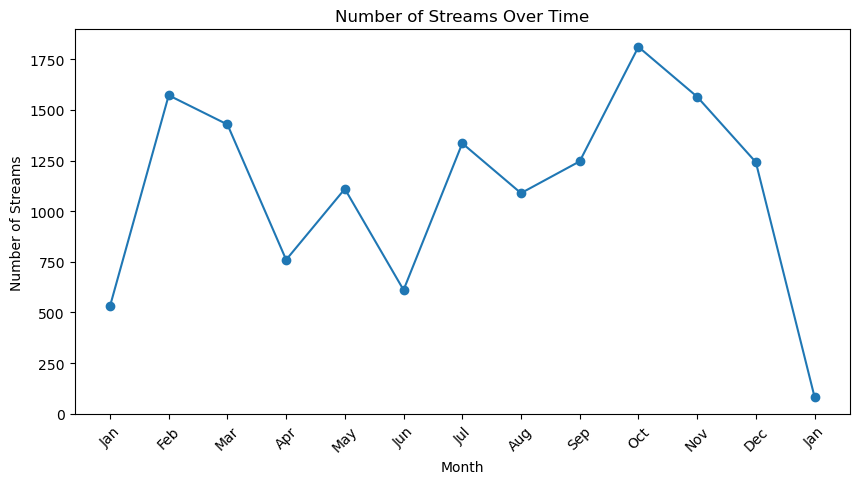

In [11]:
# To prepare for plotting, I converted the PeriodIndex to string for both monthly and weekly statistics.
monthly_stats.index = monthly_stats.index.astype(str)
weekly_stats.index = weekly_stats.index.astype(str)

# Plotting the results using line charts with markers and connecting lines.
plt.figure(figsize=(10, 5))

# Line chart for monthly number of streams
plt.plot(monthly_stats[('msPlayed', 'count')], marker='o', linestyle='-', label='Monthly Number of Streams')

# Format x-axis ticks with month names
plt.xticks(range(len(monthly_stats.index)), [calendar.month_abbr[int(month.split('-')[1])] for month in monthly_stats.index], rotation=45)


# Adding title and labels to the plot
plt.title('Number of Streams Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Streams')


Basically, this code creates a line chart to illustrate the monthly total play duration over time. The x-axis ticks are formatted with abbreviated month names for better readability. The plot provides a visual representation of how my total play duration on Spotify varies month by month.

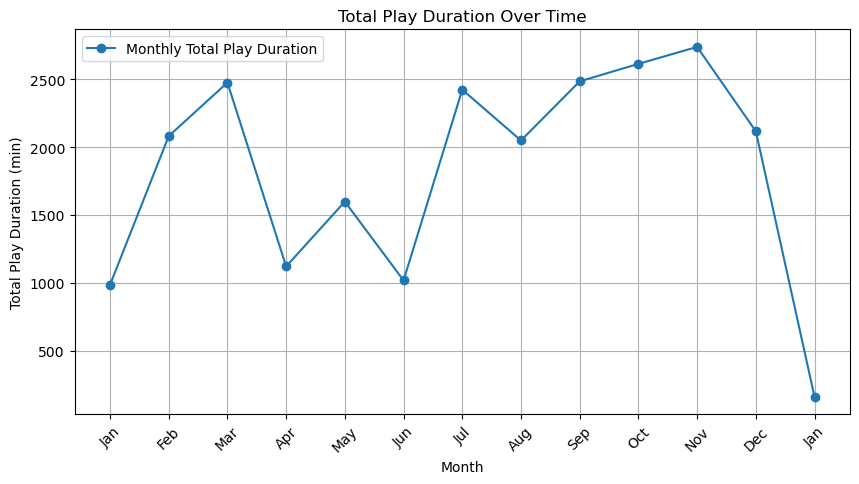

In [12]:
# Creating a line chart to visualize the monthly total play duration over time
plt.figure(figsize=(10, 5))

# Line chart representing the monthly total play duration
plt.plot(monthly_stats[('msPlayed', 'sum')], marker='o', linestyle='-', label='Monthly Total Play Duration')

# Adding title and labels to the plot
plt.title('Total Play Duration Over Time')
plt.xlabel('Month')
plt.ylabel('Total Play Duration (min)')

# Format x-axis ticks with month names
plt.xticks(range(len(monthly_stats.index)), [calendar.month_abbr[int(month.split('-')[1])] for month in monthly_stats.index], rotation=45)

# Displaying legend, grid, and the plot
plt.legend()
plt.grid(True)
plt.show()

This code segment adds a new 'weekday' column to the DataFrame, indicating the day of the week for each entry. It then groups the data by weekday, calculating the count and total play duration, and converts the total play duration from milliseconds to minutes. This analysis provides insights into my Spotify streaming habits on different days of the week.

In [13]:
# Creating a new column 'weekday' in the DataFrame to represent the day of the week (0 = Monday, 6 = Sunday)
time_df['weekday'] = time_df['endTime'].dt.dayofweek

# Grouping the data by weekday and aggregating the number of streams and total play duration
week_stats = time_df.groupby('weekday').agg({
    'msPlayed': ['count', 'sum']
})

# Converting total play duration from milliseconds to minutes for better readability
week_stats[('msPlayed', 'sum')] /= (1000 * 60)


Generates a bar chart to illustrate the number of streams for each day of the week. The x-axis is labeled with abbreviated weekdays ('Mon', 'Tue', ..., 'Sun'). The plot provides a visual representation of my Spotify streaming activity throughout the week.

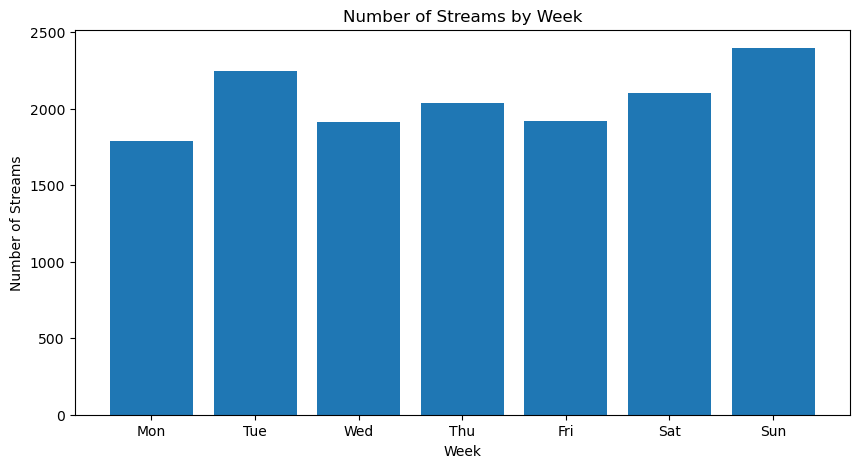

In [14]:
#---------------------------       WEEKLY STREAMING
# Creating a bar chart to visualize the number of streams by weekday
plt.figure(figsize=(10, 5))

# Bar chart representing the number of streams for each weekday
plt.bar(week_stats.index, week_stats[('msPlayed', 'count')], tick_label=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Adding title and labels to the plot
plt.title('Number of Streams by Week')
plt.xlabel('Week')
plt.ylabel('Number of Streams')

# Displaying the plot
plt.show()


generates a bar chart to illustrate the total play duration for each day of the week. The x-axis is labeled with abbreviated weekdays ('Mon', 'Tue', ..., 'Sun'). The plot offers a visual representation of the cumulative play duration on different weekdays.

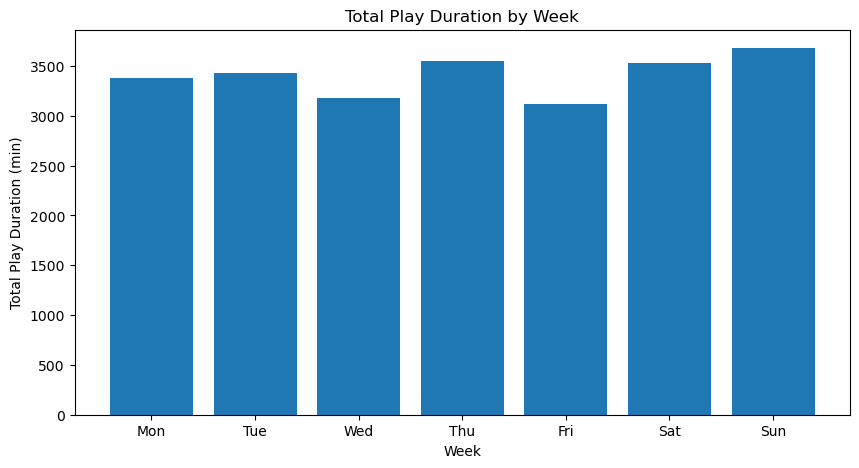

In [15]:
# Creating a bar chart to visualize the total play duration by weekday
plt.figure(figsize=(10, 5))

# Bar chart representing the total play duration for each weekday
plt.bar(week_stats.index, week_stats[('msPlayed', 'sum')], tick_label=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Adding title and labels to the plot
plt.title('Total Play Duration by Week')
plt.xlabel('Week')
plt.ylabel('Total Play Duration (min)')

plt.show()

In summary, this code, groups combined DataFrame by 'artistName' and calculates the total playtime for each artist in minutes. It then identifies and visualizes the top 20 artists with the highest total playtime using a bar chart. The plot provides a snapshot of my most-listened-to artists on Spotify.

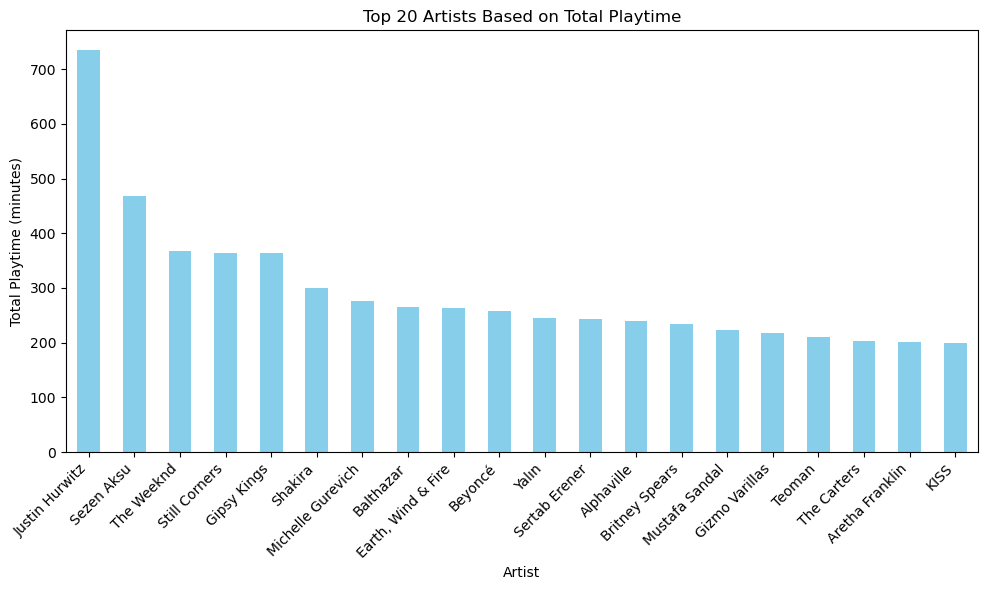

In [16]:
######################## TOP ARTISTS 

# Grouping the combined DataFrame by 'artistName' and calculating the total playtime in milliseconds
artist_playtime = combined_df.groupby('artistName')['msPlayed'].sum()

# Converting total playtime from milliseconds to minutes
artist_playtime_minutes = artist_playtime / (1000 * 60)

# Sorting artists based on playtime in descending order and selecting the top 20
top_artists = artist_playtime_minutes.sort_values(ascending=False).head(20)

# Creating a bar chart to visualize the top 20 artists based on total playtime
plt.figure(figsize=(10, 6))
top_artists.plot(kind='bar', color='skyblue')

# Adding title and labels to the plot
plt.title('Top 20 Artists Based on Total Playtime')
plt.xlabel('Artist')
plt.ylabel('Total Playtime (minutes)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Displaying the plot
plt.show()


This code groups your combined DataFrame by 'trackName', calculates the total playtime for each track in minutes, and then identifies and visualizes the top 20 tracks with the highest total playtime using a bar chart. The plot provides insights into your most-played tracks on Spotify.

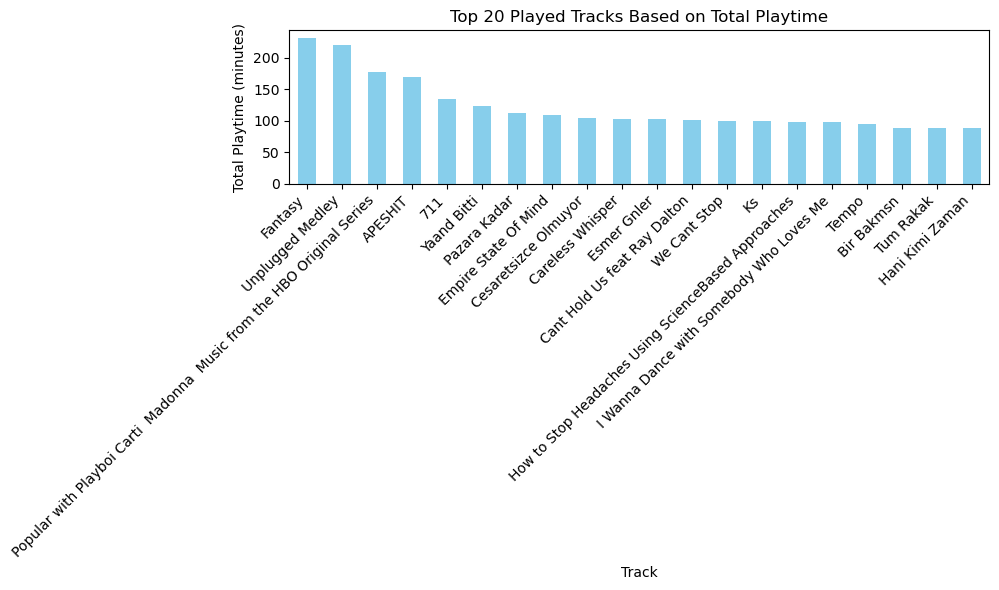

In [17]:
# Grouping the combined DataFrame by 'trackName' and calculating the total playtime in milliseconds
track_playtime = combined_df.groupby('trackName')['msPlayed'].sum()

# Converting total playtime from milliseconds to minutes
track_playtime_minutes = track_playtime / (1000 * 60)

# Sorting tracks based on playtime in descending order and selecting the top 20
top_tracks = track_playtime_minutes.sort_values(ascending=False).head(20)

# Creating a bar chart to visualize the top 20 tracks based on total playtime
plt.figure(figsize=(10, 6))
top_tracks.plot(kind='bar', color='skyblue')

# Adding title and labels to the plot
plt.title('Top 20 Played Tracks Based on Total Playtime')
plt.xlabel('Track')
plt.ylabel('Total Playtime (minutes)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Displaying the plot
plt.show()


Converts the total playtime for each track from milliseconds to minutes, filters out tracks with playtime larger than 0 (excluding tracks you haven't played), sorts the tracks in ascending order, and selects the bottom 20 tracks. 

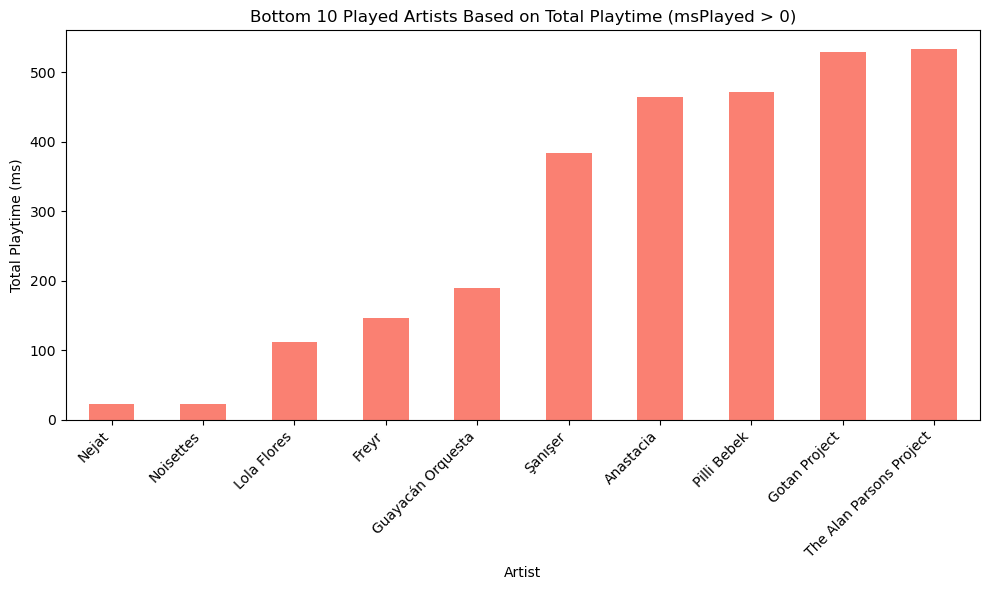

In [29]:
# Filter out rows where msPlayed is greater than 0
filtered_df = combined_df[combined_df['msPlayed'] > 0]

# Group by artistName and calculate the sum of msPlayed
bottom_artists = filtered_df.groupby('artistName')['msPlayed'].sum().sort_values().head(10)

# Plot the bottom 10 artists with a bar chart
plt.figure(figsize=(10, 6))
bottom_artists.plot(kind='bar', color='salmon')
plt.title('Bottom 10 Played Artists Based on Total Playtime (msPlayed > 0)')
plt.xlabel('Artist')
plt.ylabel('Total Playtime (ms)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the plot
plt.show()

This code filters out rows where playtime is greater than 0, groups the resulting DataFrame by 'artistName', calculates the total playtime for each artist in milliseconds, and selects the bottom 10 artists. The resulting bar chart visualizes the artists I've played the least on Spotify based on total playtime. 

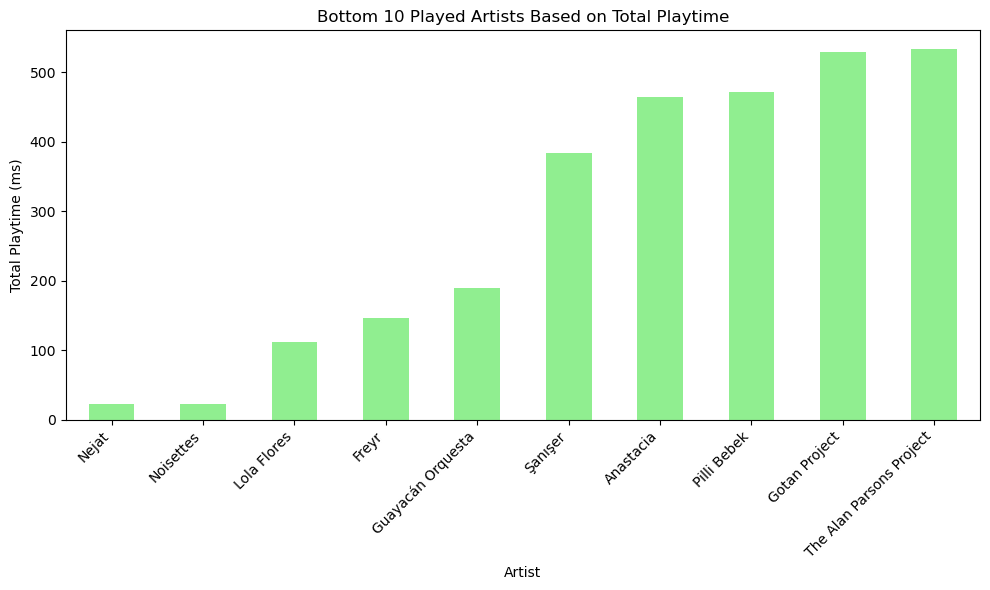

In [30]:
# Filter out rows where msPlayed is greater than 0
filtered_df = combined_df[combined_df['msPlayed'] > 0]

# Group by artistName and calculate the sum of msPlayed
bottom_artists = filtered_df.groupby('artistName')['msPlayed'].sum().sort_values().head(10)

# Plot the bottom 10 artists with a bar chart
plt.figure(figsize=(10, 6))
bottom_artists.plot(kind='bar', color='lightgreen')
plt.title('Bottom 10 Played Artists Based on Total Playtime')
plt.xlabel('Artist')
plt.ylabel('Total Playtime (ms)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the artist plot
plt.show()

This code reads a CSV file named 'allPlaylistsAnalysis.csv' into a DataFrame. It uses the 'python' engine and specifies the delimiter as ';' to handle parsing. The code captures and prints any skipped lines during reading. Finally, it displays unique playlist names, general information about the DataFrame, and the first 20 rows of the DataFrame for inspection.

In [21]:
# Specify the path to the 'allPlaylistsAnalysis.csv' file on your Desktop
file_path3 = os.path.expanduser("~/Desktop/allPlaylistsAnalysis.csv")

# Read the CSV file into a DataFrame, capturing skipped lines
try:
    df = pd.read_csv(file_path3, engine='python', delimiter=';', on_bad_lines=lambda x: print(f"Skipped line: {x}"))

except pd.errors.ParserError as e:
    print(f"Error: {e}")

print(df['playlistName'].unique())
print(df.info())    
print(df.head(20))


['kasım 2023.csv' "yaz'23.csv" '2023.csv' 'fall.csv' '2022.csv' 'spor.csv'
 '2021.csv' '🌊.csv' '🧡.csv' 'son gün🍃.csv' '(g)oldies.csv' 'yol 🛣.csv'
 'fr.csv' 'mode 📍.csv' '24_7.csv' 'my type of hype💃🏻🕺🏼.csv' 'akşam.csv'
 'classical🎹.csv' 'internationals🌍.csv' 'can’t stop.csv' 'canada🇨🇦.csv'
 'morning☕️.csv ']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   #                  27 non-null     float64
 1   Song               768 non-null    object 
 2   Artist             768 non-null    object 
 3   Popularity         768 non-null    object 
 4   BPM                768 non-null    int64  
 5   Genres             725 non-null    object 
 6   Parent Genres      723 non-null    object 
 7   Album              768 non-null    object 
 8   Album Date         768 non-null    object 
 9   Time               768 non-null    object 
 10  Dance

In summary, this code processes genre information from the 'Genres' column in your DataFrame. It splits the genres, counts their occurrences, selects the top 10 genres, creates a DataFrame for visualization, and finally, plots a pie chart to display the distribution of these top genres.

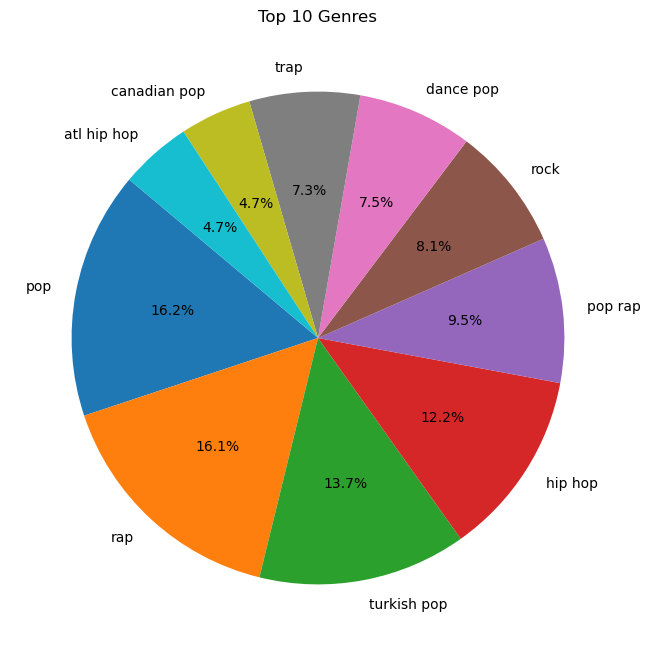

In [31]:
# Splitting genres by comma in the 'Genres' column
genres_list = df['Genres'].str.split(',').dropna().apply(lambda x: [genre.strip() for genre in x]).tolist()

# Creating a Counter to count each individual genre occurrence
genre_counts = Counter([genre for sublist in genres_list for genre in sublist])

# Selecting the top 10 genres based on counts
top_genres = dict(genre_counts.most_common(10))

# Creating a DataFrame to represent the top genres and their counts
top_genres_df = pd.DataFrame(list(top_genres.items()), columns=['Genre', 'Count'])

# Plotting a pie chart to visualize the distribution of the top 10 genres
plt.figure(figsize=(8, 8))
plt.pie(top_genres_df['Count'], labels=top_genres_df['Genre'], autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Genres')
plt.show()


2. HYPOTHESES TESTING


HYPOTHESIS 1: I tend to listen to more music during weekdays compared to weekends.

Null Hypothesis (H0): There is no significant difference in the average number of streams between weekdays and weekends.

Alternative Hypothesis (H1): The average number of streams is higher during weekdays compared to weekends.

The provided code conducts t-tests to compare the number of streams and total play duration between weekdays and weekends. The results show t-statistics and p-values for both tests. In this case, a negative t-statistic suggests that, on average, there are fewer streams on weekends compared to weekdays. However, the p-value of 0.134 is greater than the typical significance level of 0.05. Therefore, you fail to reject the null hypothesis, indicating that there is not enough evidence to claim a significant difference in the number of streams between weekdays and weekends.

In [23]:
# Group the data by weekday and aggregate the number of streams and total play duration
weekday_stats = time_df[time_df['weekday'] < 5].groupby('weekday').agg({
    'msPlayed': ['count', 'sum']
})

weekend_stats = time_df[time_df['weekday'] >= 5].groupby('weekday').agg({
    'msPlayed': ['count', 'sum']
})

# Convert total play duration from milliseconds to minutes
weekday_stats[('msPlayed', 'sum')] /= (1000 * 60)
weekend_stats[('msPlayed', 'sum')] /= (1000 * 60)

# Perform t-test for number of streams
t_stat_streams, p_value_streams = ttest_ind(weekday_stats[('msPlayed', 'count')], weekend_stats[('msPlayed', 'count')])

# Perform t-test for total play duration
t_stat_duration, p_value_duration = ttest_ind(weekday_stats[('msPlayed', 'sum')], weekend_stats[('msPlayed', 'sum')])

# Print the results
print(f"T-test results for Number of Streams: T-statistic = {t_stat_streams}, P-value = {p_value_streams}")
print(f"T-test results for Total Play Duration: T-statistic = {t_stat_duration}, P-value = {p_value_duration}")


T-test results for Number of Streams: T-statistic = -1.7859725991349067, P-value = 0.1341589896098984
T-test results for Total Play Duration: T-statistic = -1.937954910470199, P-value = 0.11035960860026293


HYPOTHESIS 2: Artist preferences affect number of streams I have. Certain artists have a significantly higher number of streams compared to others.

Null Hypothesis (H0): There is no significant difference in the average number of streams among different artists.
Alternative Hypothesis (H1): Certain artists have a significantly higher number of streams compared to others.
We first group the data by artist and aggregate the number of streams for each artist.
We then select the top 5 artists with the highest number of streams. The code then performs pairwise comparisons for the top artists using t-tests.

In [24]:
# Calculate total play duration for each artist
artist_stats = combined_df.groupby('artistName')['msPlayed'].agg(['count', 'sum']).reset_index()
artist_stats.columns = ['artistName', 'numStreams', 'totalPlayDuration']

# Identify the top 5 artists based on total play duration
top_artists = artist_stats.nlargest(5, 'totalPlayDuration')['artistName'].tolist()

# Display the top artists
print("Top 5 Artists:")
print(artist_stats.nlargest(5, 'totalPlayDuration'))

# Perform pairwise comparisons for the top artists
for i in range(len(top_artists)):
    for j in range(i+1, len(top_artists)):
        artist1 = top_artists[i]
        artist2 = top_artists[j]
        
        # Extract data for the selected artists
        data_artist1 = combined_df.loc[combined_df['artistName'] == artist1, 'msPlayed']
        data_artist2 = combined_df.loc[combined_df['artistName'] == artist2, 'msPlayed']

        # Skip the comparison if there is not enough data
        if data_artist1.shape[0] < 2 or data_artist2.shape[0] < 2:
            print(f'Skipping comparison for {artist1} vs {artist2} due to insufficient data.')
            continue

        # Perform t-test
        t_statistic, p_value = ttest_ind(data_artist1, data_artist2, equal_var=False)

        # Display the results
        print(f'T-Statistic for {artist1} vs {artist2}: {t_statistic}')
        print(f'P-Value: {p_value}')

        # Check if the p-value is below the significance level (e.g., 0.05) to reject the null hypothesis
        if p_value < 0.05:
            print(f'Reject the null hypothesis. There is a significant difference between {artist1} and {artist2}.')
        else:
            print(f'Fail to reject the null hypothesis. There is no significant difference between {artist1} and {artist2}.')
        print('\n')

Top 5 Artists:
          artistName  numStreams  totalPlayDuration
1036  Justin Hurwitz         743           44058756
1780      Sezen Aksu         286           28060193
2003      The Weeknd         205           22049768
1864   Still Corners         138           21876610
782      Gipsy Kings         190           21831912
T-Statistic for Justin Hurwitz vs Sezen Aksu: -5.515185738538943
P-Value: 6.503484495354607e-08
Reject the null hypothesis. There is a significant difference between Justin Hurwitz and Sezen Aksu.


T-Statistic for Justin Hurwitz vs The Weeknd: -6.464543287548872
P-Value: 4.980616123789193e-10
Reject the null hypothesis. There is a significant difference between Justin Hurwitz and The Weeknd.


T-Statistic for Justin Hurwitz vs Still Corners: -9.806032155367413
P-Value: 5.485908715348248e-18
Reject the null hypothesis. There is a significant difference between Justin Hurwitz and Still Corners.


T-Statistic for Justin Hurwitz vs Gipsy Kings: -7.6029111006587105
P-V

HYPOTHESIS 3: Seasonal Variations Impact Listening Habits on Spotify

We are extracting relevant date features from the 'endTime' column and visualizing the overall trend of the number of streams over time. Additionally, we are performing seasonal decomposition to visualize trends, seasonality, and residuals. Finally, we are conducting a one-way ANOVA test to check for significant differences between seasons.. In statistical terms, a p-value is used to assess the evidence against a null hypothesis. A very low p-value, such as the one obtained in this case, suggests strong evidence against the null hypothesis. Therefore, in the context of the seasonal analysis, the obtained p-value strongly supports the idea that there are significant differences between seasons in terms of the total play duration of Spotify streams.

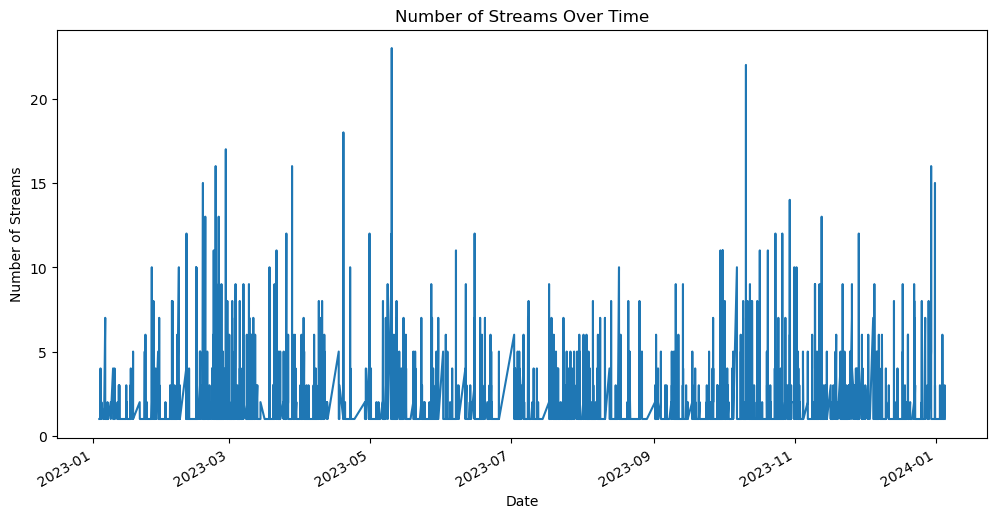

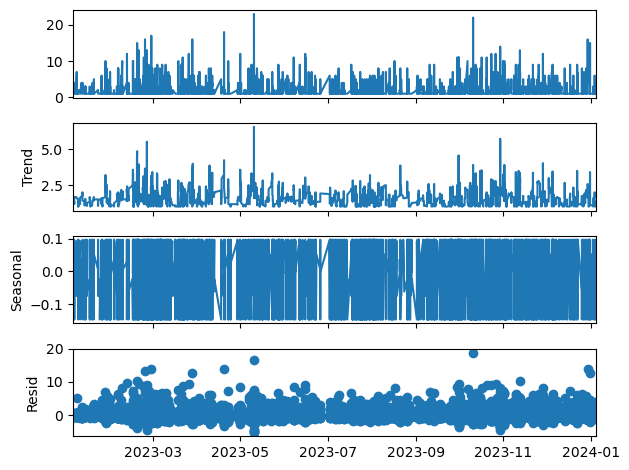

ANOVA p-value: 1.1947388848830155e-24


In [25]:

# Extract relevant date features
time_df['month'] = time_df['endTime'].dt.month
time_df['day'] = time_df['endTime'].dt.day
time_df['hour'] = time_df['endTime'].dt.hour

# Visualize overall trend
plt.figure(figsize=(12, 6))
time_df.groupby('endTime').size().plot(title='Number of Streams Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Streams')
plt.show()

# Perform seasonal decomposition to visualize trends, seasonality, and residuals
result = seasonal_decompose(time_df.groupby('endTime').size(), model='additive', period=12) 
result.plot()
plt.show()

# Perform one-way ANOVA to test for significant differences between seasons
seasonal_anova = f_oneway(*[group['msPlayed'] for name, group in time_df.groupby('month')])

# Print ANOVA results
print("ANOVA p-value:", seasonal_anova.pvalue)

In [26]:
# Assuming 'endTime' is the column with date and time information in combined_df
combined_df['endTime'] = pd.to_datetime(combined_df['endTime'])

# Define midterm dates (assuming they are in 2023)
midterm_dates = ["2023-11-01", "2023-11-06", "2023-11-08", "2023-12-04", "2023-12-11"]

# Assuming you have already defined midterm_dates and combined_df

# Convert midterm_dates to datetime format
midterm_dates = pd.to_datetime(midterm_dates, format="%Y-%m-%d")

# Define window size (a few days before and after each midterm date)
window_size = pd.Timedelta(days=3)

# Extract relevant data for each midterm period
midterm_data = pd.DataFrame()

# Assuming 'endTime' is the column with date and time information in combined_df
combined_df['endTime'] = pd.to_datetime(combined_df['endTime'], errors='coerce')

for date in midterm_dates:
    start_date = date - window_size
    end_date = date + window_size
    midterm_subset = combined_df[(combined_df['endTime'] >= start_date) & (combined_df['endTime'] <= end_date)]
    midterm_data = pd.concat([midterm_data, midterm_subset], ignore_index=True)

# Display the extracted data for midterm periods
print(midterm_data)


                 endTime                          artistName  \
0    2023-10-29 04:51:00  Scott Bradlee's Postmodern Jukebox   
1    2023-10-29 04:53:00                        Kenan Doğulu   
2    2023-10-29 08:29:00                          Marshmello   
3    2023-10-29 08:35:00                             Parcels   
4    2023-10-29 08:38:00                            Ane Brun   
...                  ...                                 ...   
1381 2023-12-13 20:13:00                               Wham!   
1382 2023-12-13 20:13:00                       Philip Bailey   
1383 2023-12-13 20:14:00                       Philip Bailey   
1384 2023-12-13 20:19:00                       Philip Bailey   
1385 2023-12-13 20:30:00                  BJ The Chicago Kid   

                                           trackName  msPlayed  
0                                           Lovesong    228359  
1                                         kinci Yzyl    130340  
2                                   

3. MACHINE LEARNING PART 

In this machine learning segment, I employed the Isolation Forest algorithm to detect anomalies within the Spotify dataset, specifically focusing on the 'secondsPlayed' column, which denotes the duration of music playback. Initially, I transformed the 'msPlayed' values into seconds for consistency and isolated the relevant data subset. The Isolation Forest model was then initiated with a contamination parameter set to 0.01, representing the expected proportion of anomalies in the dataset. Following model training on the 'secondsPlayed' data to understand normal playback patterns, the algorithm predicted anomalies by assigning outlier scores, with negative scores indicating potential anomalies. The outcomes were visually presented on a scatter plot, with data points colored according to their anomaly predictions, providing a clear representation of unusual playback durations. Additionally, rows flagged as anomalies were extracted and printed for further examination. This Isolation Forest-based anomaly detection approach serves as a valuable tool for uncovering irregularities in Spotify listening patterns, offering insights into user behavior and facilitating data quality assessment. Adjustments to model parameters and further exploration can enhance anomaly detection based on specific use cases or preferences.

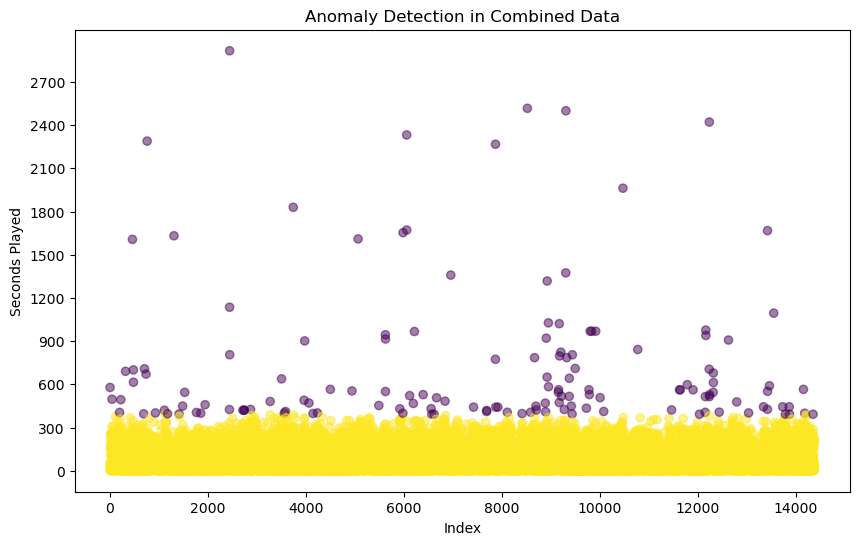

Anomalies:
                  endTime              artistName  \
1     2023-01-04 07:26:00            Huberman Lab   
41    2023-01-07 10:33:00                Coldplay   
196   2023-01-17 08:50:00            Dire Straits   
220   2023-01-18 10:20:00                   Karsu   
317   2023-01-26 15:22:00              Cem Karaca   
...                   ...                     ...   
13865 2023-12-21 16:01:00  Grover Washington, Jr.   
13870 2023-12-22 12:55:00             Nina Simone   
14155 2023-12-29 21:48:00                  Teoman   
14181 2023-12-30 10:49:00                  Teoman   
14352 2024-01-04 12:39:00                 Adamlar   

                                               trackName  msPlayed  \
1      Using Caffeine to Optimize Mental  Physical Pe...    578362   
41                                       We Never Change    496522   
196                                 When It Comes To You    404873   
220                                Domates Biber Patlcan    493568   
31

In [27]:
###################################### MACHINE LEARNING- ANOMALY DETECTION

# Convert 'msPlayed' to seconds
combined_df['secondsPlayed'] = combined_df['msPlayed'] / 1000

# Extract the 'secondsPlayed' column for anomaly detection
data_for_anomaly_detection = combined_df[['secondsPlayed']]

# Initialize the Isolation Forest model
model = IsolationForest(contamination=0.01)  # You may adjust the contamination parameter

# Fit the model to the data
model.fit(data_for_anomaly_detection)

# Predict anomalies (outliers)
anomaly_predictions = model.predict(data_for_anomaly_detection)

# Add the anomaly predictions as a new column to the DataFrame
combined_df['is_anomaly'] = anomaly_predictions

# Visualize anomalies with transparency
plt.figure(figsize=(10, 6))
plt.scatter(combined_df.index, combined_df['secondsPlayed'], c=anomaly_predictions, cmap='viridis', alpha=0.5)
plt.title('Anomaly Detection in Combined Data')
plt.xlabel('Index')
plt.ylabel('Seconds Played')

# Set y-axis ticks to a broader range for better readability
y_ticks = [0, 300, 600, 900, 1200, 1500,1800,2100,2400,2700]  # Adjust the values based on your data
plt.yticks(y_ticks)

plt.show()

# Display the rows flagged as anomalies
anomalies_df = combined_df[combined_df['is_anomaly'] == -1]
print("Anomalies:")
print(anomalies_df)


In this code snippet, a binary classification model is constructed to predict whether a user likes or dislikes a track on Spotify, relying on the 'msPlayed' duration as a key feature. The process begins with the creation of a new DataFrame, 'new_df,' derived as a copy of the original dataset 'combined_df' to prevent any modifications to the initial data. Subsequently, a liking threshold is established, denoted as 'liked_threshold,' to classify tracks as liked or disliked based on their playback duration. A binary column, 'liked,' is then appended to 'new_df,' representing whether a track is liked (1) or disliked (0) according to the defined threshold. Non-numeric categorical columns, namely 'artistName' and 'trackName,' undergo one-hot encoding for effective model processing. Optionally, certain columns like 'endTime' can be removed for data streamlining. Data preprocessing steps involve handling missing values by removing rows with incomplete data. The dataset is further segregated into features ('X') and the target variable ('y'), signifying track preferences. The dataset is split into training and testing sets for model evaluation. The chosen binary classification algorithm is the Random Forest Classifier, renowned for its robustness. The model undergoes training on the training dataset ('X_train' and 'y_train'). The final evaluation encompasses calculating and displaying key performance metrics, including accuracy, precision, recall, and F1 score, providing insights into the model's effectiveness in predicting user preferences based on track playback durations. This code serves as a comprehensive illustration of constructing, training, and assessing a binary classification model for predicting user liking behavior on Spotify. Adjustments can be made to the model or liking threshold based on specific preferences or use cases.


In [28]:
new_df = combined_df.copy()

# Define the new threshold for liking a track
liked_threshold = 100000  # Adjust the threshold based on your preference (e.g., 100,000 milliseconds)

# Add a new column indicating whether a track is liked or disliked based on 'msPlayed'
new_df['liked'] = (new_df['msPlayed'] > liked_threshold).astype(int)

# Check if 'artistName' and 'trackName' are not numeric and perform one-hot encoding
for column in ['artistName', 'trackName']:
    if not pd.api.types.is_numeric_dtype(new_df[column]):
        # Use one-hot encoding for non-numeric categorical columns
        new_df = pd.get_dummies(new_df, columns=[column])

# Remove columns 'endTime' if needed
columns_to_remove = ['endTime']
new_df = new_df.drop(columns=columns_to_remove, axis=1)

# Data Preprocessing
# Handle missing values
new_df = new_df.dropna() 

# Split the data into features (X) and target (y)
X = new_df.drop(['liked'], axis=1)
y = new_df['liked']

# Split your dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Selection: Choose a binary classification algorithm (Random Forest in this example)
model = RandomForestClassifier(random_state=42)

# Model Training
model.fit(X_train, y_train)

# Model Evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
